### Simulating Cosmic Rays
In this notebook we will go through the steps for simulating the Cosmic Rays events.

In simulating Cosmic Rays events, we need to take into account:
* the declination dependence of the exposure of the array
* the large scale anisotropy observed by PAO and confirmed at a significance level of 6.8 sigma for energyes above 8 EeV. (see https://arxiv.org/pdf/2408.05292)

These effects are well know and can be easily parametrised. This means that we can sample events according to the expected distribution. In this case, we use Inverse Transform Sampling method.

The content of this notebook consists in:
* construction of the dipole anisotropy and exposure pdf
* sampling of events using the inverse transform sampling method
* checking that the simulated distributions are in good agreement with the data
* KS test for establlishing whether the data are better described by a pdf taking into account both the dipole anisotropy and the exposure, or the exposure only

In [1]:
#usual imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.stats as stats
import sys

sys.path.append('../analysis_scripts/tools/')

from plot_utils import *

from matplotlib import colormaps

In [2]:
#some useful general functions
def smooth_flux(flux_values, sigma=1):
    """
    Smooth the flux to reduce any sharp concentration at the poles.
    """
    return gaussian_filter(flux_values, sigma=sigma)


In [3]:
def get_bin_centers(bins):
    bc = 0.5*(bins[1:]+bins[:-1])
    return bc

The Pierre Auger data release is described here (https://opendata.auger.org/) and it consists of 10% of the deta recorded by the array and the 100 most energetic events.

In this work, we use all the available data, combining the Surface Detector data with the catalog of UHECR.

In the following cell, we load some two numpy files with the summary information for all the events, divided into vertical and inclined events.
THe procedure for creating these files is descrived in this notebook (ADD LINK)

In [4]:
# read flash.dat to a list of lists
datContent = [i.strip().split() for i in open("../data/AugerApJS2022_Yr_JD_UTC_Th_Ph_RA_Dec_E_Expo.dat").readlines()]

dataset = pd.DataFrame(datContent[1:], columns=datContent[0])

for col in datContent[0]:
    dataset[col] = dataset[col].astype('float') 

mask = dataset['Th'] >= 60

In [5]:
# #load  events files

vertical_events = dataset[~mask]
inclined_events = dataset[mask]

### Exposure
The functions to describe the exposure of the Pierre Auger Observatory are the same as the ones defined in the Pierre Auger Data Release (link).

Only minor changes where made for our specific case.

In [6]:
def exposure(dec, theta_max=np.radians(60)):
    """
    Compute the Auger exposure as a function of declination, accounting for vertical and inclined events.

    Parameters:
    dec (array-like): Declination values (radians).
    theta_max (float): Maximum zenith angle for detection (radians).

    Returns:
    array-like: Relative exposure values.
    """
    l = np.radians(-35.23)  # Latitude of Malargüe, Argentina
    arg = (np.cos(theta_max) - np.sin(l) * np.sin(dec)) / (np.cos(l) * np.cos(dec))
    hm = np.arccos(arg.clip(-1, 1))

    exposure = np.cos(l) * np.cos(dec) * np.sin(hm) + hm * np.sin(l) * np.sin(dec)
    
    return exposure


In [7]:
def LoadExposureMap(theta_max_vert, theta_max_incl,  dec):

    # Compute the exposure_map for each pixel regarding its declination.
    exposure_map_total = exposure(dec, np.radians(theta_max_incl)) # Exposure from 0° to 80°
    exposure_map_vert = exposure(dec, np.radians(theta_max_vert))  # Exposure from 0° to 60°

    exposure_map_incl = (exposure_map_total - exposure_map_vert) # Exposure from 60° to 80°
    
    exposure_map_incl = exposure_map_incl / np.sum(exposure_map_incl) # Normalized
    exposure_map_vert = exposure_map_vert/np.sum(exposure_map_vert) # Normalized
    exposure_map_total = exposure_map_incl + exposure_map_vert # Total exposure
    
    return exposure_map_vert, exposure_map_incl, exposure_map_total

### Dipole

Function to the describe the dipole anisotropy

In [8]:
def dipole_flux(alpha, delta, d, alpha_d, delta_d):
    """
    2D Dipole flux distribution function in RA and Dec.
    
    Parameters:
    alpha (float or np.array): Right ascension (RA) in radians.
    delta (float or np.array): Declination (Dec) in radians.
    d (float): Dipole amplitude.
    alpha_d (float): RA of dipole direction in radians.
    delta_d (float): Dec of dipole direction in radians.
    
    Returns:
    float or np.array: Normalized dipole flux at (alpha, delta).
    """
    # Compute dipole components
    d_x = d * np.cos(alpha_d) * np.cos(delta_d)
    d_y = d * np.sin(alpha_d) * np.cos(delta_d)
    d_z = d * np.sin(delta_d)
    
    dipole_modulation =1 + d_x * np.cos(alpha) * np.cos(delta) + d_y * np.sin(alpha) * np.cos(delta) + d_z * np.sin(delta)

    return dipole_modulation

Let's plot the exposure PDF. It depends on the declination of the events only, and we want to make sure that it looks quite smooth, to ensure that the sampling happens quite smoothly as well.

In [9]:
# Define a fine 2D grid for RA and Dec
ra_bins = np.linspace(0, 2 * np.pi, 1000)
sindec_bins = np.linspace(-1, 1, 1000)
ra_grid, dec_grid = np.meshgrid(ra_bins, sindec_bins)

Text(0.5, 0.95, 'Exposure PDF for vertical events')

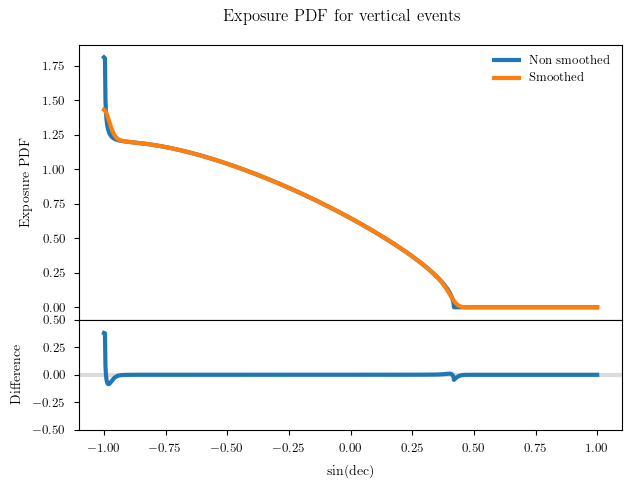

In [10]:
fig, ax = plt.subplots(2,1, figsize=(7, 5), height_ratios=[2.5,1], sharex = 'col', gridspec_kw = {'hspace': 0})

exposure_vert = exposure(np.arcsin(dec_grid),np.radians(60))
ax[0].plot(sindec_bins,exposure_vert[:,-1], label = "Non smoothed")
#we neet to apply a smoothing to make sure that there are no abrupt changes in our PDFs
exposure_smooth_vert = smooth_flux(exposure_vert, sigma=10)
ax[0].plot(sindec_bins,exposure_smooth_vert[:,-1], label = "Smoothed")
ax[0].legend(frameon = False)
ax[0].set_ylabel("Exposure PDF")

ax[1].plot(sindec_bins, exposure_vert[:,-1]-exposure_smooth_vert[:,-1])
ax[1].axhline(0, color='gainsboro', zorder = -1)
ax[1].set_xlabel("sin(dec)")
ax[1].set_ylabel("Difference")
ax[1].set_ylim(-0.5,0.5)
plt.suptitle("Exposure PDF for vertical events", y = 0.95)


Text(0.5, 0.95, 'Exposure PDF for inclined events')

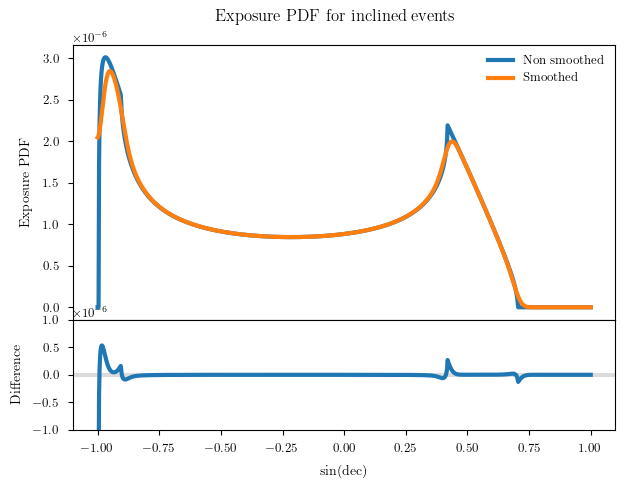

In [11]:
exposure_vert, exposure_incl, exposure_tot = LoadExposureMap(60, 80, np.arcsin(dec_grid))
fig, ax = plt.subplots(2,1, figsize=(7, 5), height_ratios=[2.5,1], sharex = 'col', gridspec_kw = {'hspace': 0})
ax[0].plot(sindec_bins,exposure_incl[:,-1], label = "Non smoothed")
exposure_smooth_incl = smooth_flux(exposure_incl, sigma=10)
ax[0].plot(sindec_bins,exposure_smooth_incl[:,-1], label = "Smoothed")
ax[0].legend(frameon = False)
ax[0].set_ylabel("Exposure PDF")

ax[1].plot(sindec_bins, exposure_incl[:,-1]-exposure_smooth_incl[:,-1])
ax[1].axhline(0, color='gainsboro', zorder = -1)
ax[1].set_xlabel("sin(dec)")
ax[1].set_ylabel("Difference")
ax[1].set_ylim(-1e-6,1e-6)
plt.suptitle("Exposure PDF for inclined events", y = 0.95)

Text(0.5, 0, 'sin($\\delta$)')

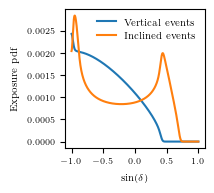

In [12]:
fig, ax = plt.subplots(1,1, figsize=(set_size('margin', fraction=0.9, ratio = 1)))

exposure_vert = exposure(np.arcsin(dec_grid),np.radians(60))
exposure_smooth_vert = smooth_flux(exposure_vert, sigma=10)
ax.plot(sindec_bins,exposure_smooth_vert[:,-1]/np.sum(exposure_smooth_vert[:,-1]), label = "Vertical events")
exposure_vert, exposure_incl, exposure_tot = LoadExposureMap(60, 80, np.arcsin(dec_grid))
exposure_smooth_incl = smooth_flux(exposure_incl, sigma=10)
ax.plot(sindec_bins,exposure_smooth_incl[:,-1]/np.sum(exposure_smooth_incl[:,-1]), label = "Inclined events")
ax.legend(frameon = False)
ax.set_ylabel("Exposure pdf")
ax.set_xlabel("sin($\delta$)")


The smoothed PDFs look fine. Now let's plot them in 2D

Now the dipole

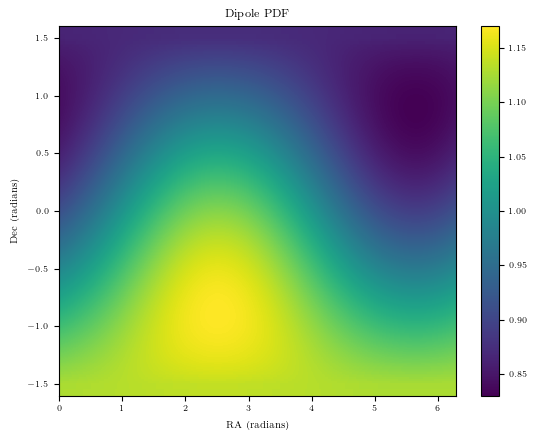

In [13]:
# dipole parameters as per https://arxiv.org/pdf/2408.05292
# d,  alpha_d, delta_d = 0.074, np.radians(97), np.radians(-38)
d,  alpha_d, delta_d = 0.17, np.radians(144), np.radians(-51)

# Compute dipole flux over the 2D grid
flux_values = dipole_flux(ra_grid, np.arcsin(dec_grid), d,  alpha_d, delta_d)
flux_values = smooth_flux(flux_values, sigma=2.0)

plt.pcolormesh(ra_grid,np.arcsin(dec_grid),flux_values)
plt.colorbar()
plt.title("Dipole PDF")
plt.xlabel("RA (radians)")
plt.ylabel("Dec (radians)")
plt.savefig('plots/dipole_pdf.png')


And finally, we plot the convolution of the two

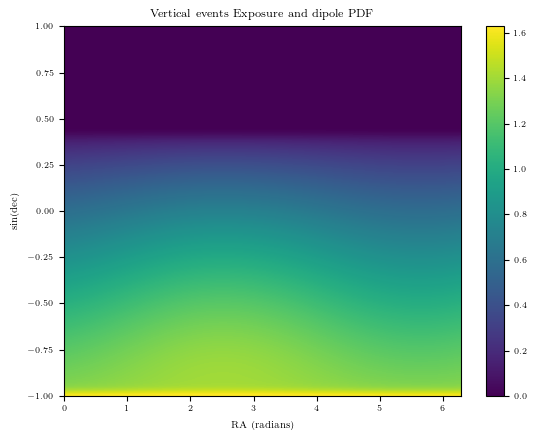

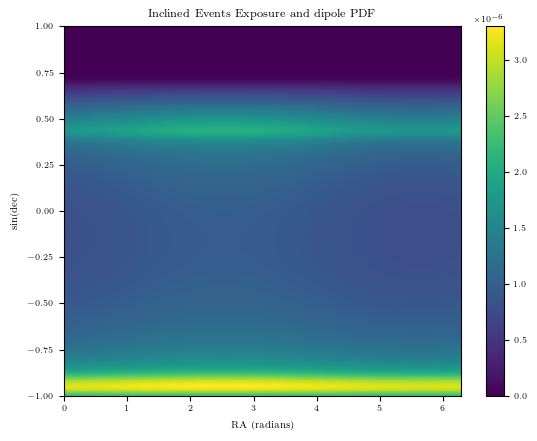

In [14]:
plt.pcolormesh(ra_grid,dec_grid,flux_values*exposure_smooth_vert)
plt.colorbar()
plt.title("Vertical events Exposure and dipole PDF")
plt.xlabel("RA (radians)")
plt.ylabel("sin(dec)")
plt.savefig('plots/exposure_and_dipole_vertical_pdf.png')
plt.show()

plt.pcolormesh(ra_grid,dec_grid,flux_values*exposure_smooth_incl)
plt.colorbar()
plt.title("Inclined Events Exposure and dipole PDF")
plt.xlabel("RA (radians)")
plt.ylabel("sin(dec)")
plt.savefig('plots/exposure_and_dipole_inclined_pdf.png')
plt.show()

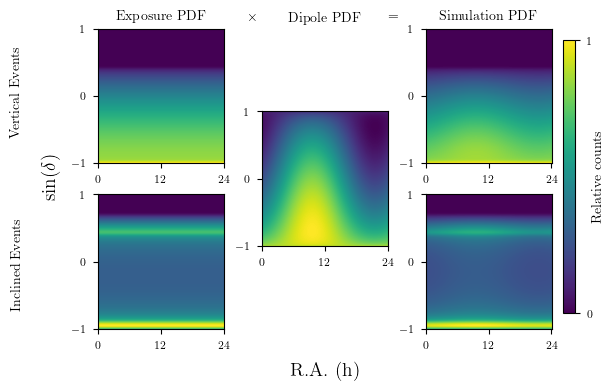

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create figure with a 2x3 grid
# Make a 4x3 grid (instead of 2x3)
fig = plt.figure(figsize=set_size('text', fraction=0.9, subplots=(2, 3), ratio=1))
gs = gridspec.GridSpec(4, 3, figure=fig, wspace=0.3, hspace=0.6)

# Column 1
ax1 = fig.add_subplot(gs[0:2, 0])  # vertical
ax4 = fig.add_subplot(gs[2:4, 0])  # inclined

# Column 2 (dipole, centered)
ax2 = fig.add_subplot(gs[1:3, 1])  # spans two middle rows

# Column 3
ax3 = fig.add_subplot(gs[0:2, 2])  # vertical
ax6 = fig.add_subplot(gs[2:4, 2])  # inclined

# Example plotting
im1 = ax1.pcolormesh(ra_grid, dec_grid, exposure_smooth_vert/exposure_smooth_vert.max())
ax1.set_ylabel("sin($\delta$)", y = -0.1, size = 14)
ax1.set_yticks([-1,0,1])
ax1.set_xticks([0, np.pi, 2*np.pi])
ax1.set_xticklabels(['0', '12', '24'])
ax1.set_title("Exposure PDF", size = 10)
ax1.text(1.2,1.07, r'$\times$', transform=ax1.transAxes)
ax1.text(-0.7,0.2, r'Vertical Events', transform=ax1.transAxes, rotation=90)

ax4.pcolormesh(ra_grid, dec_grid, exposure_smooth_incl/exposure_smooth_incl.max())
ax4.set_yticks([-1,0,1])
ax4.set_xticks([0, np.pi, 2*np.pi])
ax4.set_xticklabels(['0', '12', '24'])
ax4.text(-0.7,0.15, r'Inclined Events', transform=ax4.transAxes, rotation=90)


ax2.pcolormesh(ra_grid, dec_grid, flux_values/flux_values.max()) 
ax2.set_yticks([-1,0,1])
ax2.set_xticks([0, np.pi, 2*np.pi])
ax2.set_xticklabels(['0', '12', '24'])
ax2.set_title("Dipole PDF", y = 1.6, size = 10)


ax3.pcolormesh(ra_grid, dec_grid, flux_values * exposure_smooth_vert/(flux_values * exposure_smooth_vert).max())
ax3.set_yticks([-1,0,1])
ax3.set_xticks([0, np.pi, 2*np.pi])
ax3.set_xticklabels(['0', '12', '24'])
ax3.set_title("Simulation PDF", size = 10)
ax3.text(-.3,1.07, r'$=$', transform=ax3.transAxes)

ax6.pcolormesh(ra_grid, dec_grid, flux_values * exposure_smooth_incl/(flux_values * exposure_smooth_incl).max())
ax6.set_xlabel("R.A. (h)", x = -0.8, size = 14)
ax6.set_yticks([-1,0,1])
ax6.set_xticks([0, np.pi, 2*np.pi])
ax6.set_xticklabels(['0', '12', '24'])
# --- Shared colorbar outside the grid ---
# manually allocate space [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Relative counts", labelpad =0 )
cbar.set_ticks([0, 1])

plt.savefig('plots/combined_exposure_and_dipole.pdf', bbox_inches='tight')
plt.savefig('plots/combined_exposure_and_dipole.png', bbox_inches='tight')


### Events Simulation
Let's now get ready for the simulation part. First, we need to normalize our PDFs.

In [16]:
pdf_vert = flux_values*exposure_smooth_vert/np.sum(flux_values*exposure_smooth_vert)
pdf_incl = flux_values*exposure_smooth_incl/np.sum(flux_values*exposure_smooth_incl)

In [17]:
def do_simulation(pdf_vertical, pdf_inclined, n_events_vert, n_events_incl, ra_bins, dec_bins, seed):
    '''This function contains all the steps 
    for sampling events with the Inverse 
    Transform Sampling Method.

    Input Parameters:
    - pdf for vertical events
    - pdf for inclined events
    - number of vertical events we want to simulate
    - number of inclined events we want to simulate
    - bins in right ascension
    - bins in declination
    - seed for the sampling
    
    Returns:
    - ra and dec simulated array for both vertical and inclined events'''
    
    # Compute the cumulative distribution function (CDF) # Normalize to form a probability density
    cdf_2d_vert = np.cumsum(pdf_vertical, axis=1)  # Compute along RA first
    cdf_2d_vert = np.cumsum(cdf_2d_vert, axis=0)  # Then along Dec
    cdf_2d_vert /= cdf_2d_vert[-1, -1]  # Normalize to form a probability density

    # Compute the cumulative distribution function (CDF) # Normalize to form a probability density
    cdf_2d_incl = np.cumsum(pdf_inclined, axis=1)  # Compute along RA first
    cdf_2d_incl = np.cumsum(cdf_2d_incl, axis=0)  # Then along Dec
    cdf_2d_incl /= cdf_2d_incl[-1, -1]  # Normalize to form a probability density

    # Generate uniform random numbers for sampling
    random_ra_vals = np.random.rand(n_events_vert)
    random_dec_vals = np.random.rand(n_events_vert)
    # Use interpolation to map random values to RA and Dec
    # Invert the CDF to get RA and Dec
    scrambled_ra_vert= np.interp(random_ra_vals, get_bin_centers(cdf_2d_vert.T[:, -1]), get_bin_centers(ra_bins))  # Solve for RA
    scrambled_dec_vert = np.interp(random_dec_vals, get_bin_centers(cdf_2d_vert.T[-1, :]), get_bin_centers(dec_bins))

    # Generate uniform random numbers for sampling.
    # We need two different seeds to make sure the events are evenly distributed in the Sky
    np.random.seed(seed)
    random_ra_vals_incl = np.random.rand(n_events_incl)
    np.random.seed(seed+1)
    random_dec_vals_incl = np.random.rand(n_events_incl)
    # Use interpolation to map random values to RA and Dec
    # Invert the CDF to get RA and Dec
    scrambled_ra_incl = np.interp(random_ra_vals_incl, get_bin_centers(cdf_2d_incl.T[:, -1]), get_bin_centers(ra_bins))  # Solve for RA
    scrambled_dec_incl = np.interp(random_dec_vals_incl, get_bin_centers(cdf_2d_incl.T[-1, :]), get_bin_centers(dec_bins))

    return scrambled_ra_vert, scrambled_dec_vert, scrambled_ra_incl, scrambled_dec_incl


In [18]:
#some data arrays 
ra_vert = np.radians(vertical_events['RA'])
dec_vert = np.radians(vertical_events['Dec'])
energy_vert = vertical_events['E']

ra_incl = np.radians(inclined_events['RA'])
dec_incl = np.radians(inclined_events['Dec'])
energy_incl = inclined_events['E']

### We are ready to simulate! 

Run one simulation and compare the output with the data

In [19]:
ra_vert_dip, dec_vert_dip, ra_incl_dip, dec_incl_dip =  do_simulation(pdf_vert, pdf_incl, len(ra_vert), len(ra_incl), ra_bins, sindec_bins, 1)
ra_vert_exp, dec_vert_exp, ra_incl_exp, dec_incl_exp =  do_simulation(exposure_smooth_vert, exposure_smooth_incl, len(ra_vert), len(ra_incl), ra_bins, sindec_bins, 1)

/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/1531344517.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 50)), counts_sim/counts_true,color = 'grey', where='mid')
/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/1531344517.py:7: RuntimeWarning: invalid value encountered in divide
  ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 50)), counts_sim/counts_true,color = 'grey', where='mid')


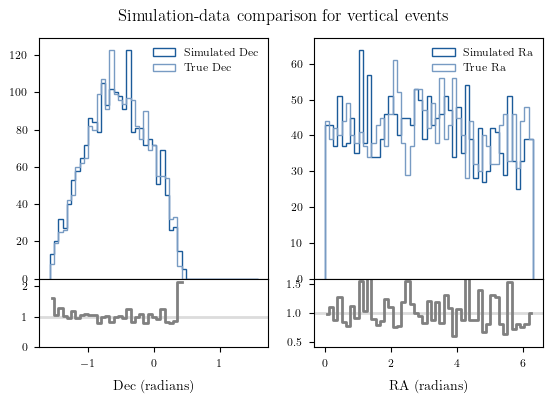

In [20]:
fig, ax = plt.subplots(2,2, figsize=(set_size('text', fraction=1, subplots=(2, 2))), height_ratios=[3.5,1], sharex = 'col', gridspec_kw = {'hspace': 0})

counts_sim, _, _ = ax[0][0].hist(np.arcsin(dec_vert_dip), histtype='step', bins=np.linspace(-np.pi/2, np.pi/2, 50), color = blues[0],label='Simulated Dec')
counts_true, _, _ = ax[0][0].hist(dec_vert, histtype='step', bins=np.linspace(-np.pi/2, np.pi/2, 50),color = blues[2], label='True Dec')
ax[0][0].legend(frameon = False)

ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 50)), counts_sim/counts_true,color = 'grey', where='mid')
ax[1][0].axhline(y = 1, c = 'gainsboro',zorder = -1 )
ax[1][0].set_ylim(0,2.25)
ax[1][0].set_xlabel('Dec (radians)')

counts_sim, _, _ = ax[0][1].hist(ra_vert_dip, histtype='step', bins=np.linspace(0, 2*np.pi, 50), color = blues[0],label='Simulated Ra')
counts_true, _, _ = ax[0][1].hist(ra_vert, histtype='step', bins=np.linspace(0, 2*np.pi, 50),color = blues[2], label='True Ra')
ax[0][1].legend(frameon = False)

ax[1][1].step(get_bin_centers(np.linspace(0, 2*np.pi, 50)), counts_sim/counts_true,color = 'grey', where='mid')
ax[1][1].axhline(y = 1, c = 'gainsboro',zorder = -1 )
ax[1][1].set_ylim(0.4,1.6)
ax[1][1].set_xlabel('RA (radians)')

plt.suptitle('Simulation-data comparison for vertical events', y = 0.95)

plt.savefig('plots/simulation_comparison_vertical_ra_dec.png')

/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/1238640695.py:7: RuntimeWarning: divide by zero encountered in divide
  ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 50)), counts_sim/counts_true,color = 'grey', where='mid')
/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/1238640695.py:7: RuntimeWarning: invalid value encountered in divide
  ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 50)), counts_sim/counts_true,color = 'grey', where='mid')


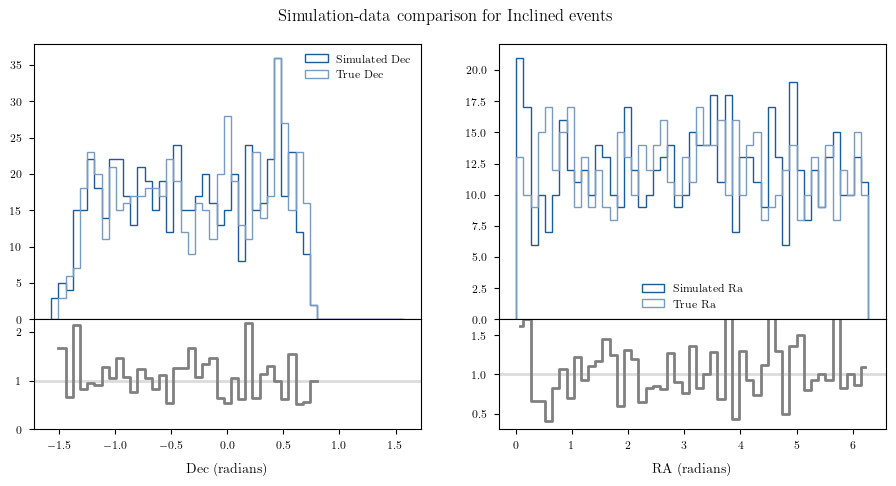

In [21]:
fig, ax = plt.subplots(2,2, figsize=(11, 5), height_ratios=[2.5,1], sharex = 'col', gridspec_kw = {'hspace': 0})

counts_sim, _, _ = ax[0][0].hist(np.arcsin(dec_incl_dip), histtype='step', bins=np.linspace(-np.pi/2, np.pi/2, 50),color = blues[0], label='Simulated Dec')
counts_true, _, _ = ax[0][0].hist(dec_incl, histtype='step', bins=np.linspace(-np.pi/2, np.pi/2, 50),color = blues[2],label='True Dec')
ax[0][0].legend(frameon = False)

ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 50)), counts_sim/counts_true,color = 'grey', where='mid')
ax[1][0].axhline(y = 1, c = 'gainsboro',zorder = -1 )
ax[1][0].set_ylim(0,2.25)
ax[1][0].set_xlabel('Dec (radians)')

counts_sim, _, _ = ax[0][1].hist(ra_incl_dip, histtype='step', bins=np.linspace(0, 2*np.pi, 50),color = blues[0], label='Simulated Ra')
counts_true, _, _ = ax[0][1].hist(ra_incl, histtype='step', bins=np.linspace(0, 2*np.pi, 50),color = blues[2], label='True Ra')
ax[0][1].legend(frameon = False)

ax[1][1].step(get_bin_centers(np.linspace(0, 2*np.pi, 50)), counts_sim/counts_true,color = 'grey', where='mid')
ax[1][1].axhline(y = 1, c = 'gainsboro',zorder = -1 )
ax[1][1].set_ylim(0.3,1.7)
ax[1][1].set_xlabel('RA (radians)')

plt.suptitle('Simulation-data comparison for Inclined events', y = 0.95)

plt.savefig('plots/simulation_comparison_inclined_ra_dec.png')

/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/220251216.py:17: RuntimeWarning: invalid value encountered in divide
  ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 20)), counts_sim/counts_true,color = 'k', where='mid')


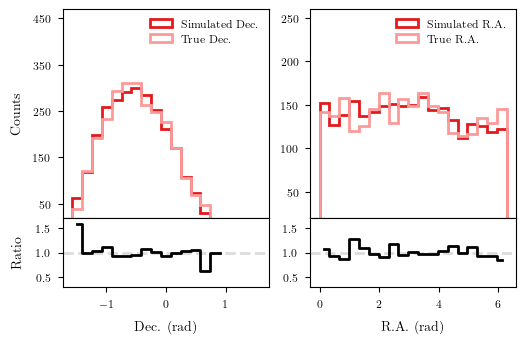

In [22]:
ra_tot, dec_tot = np.concatenate([ra_vert, ra_incl]), np.concatenate([dec_vert, dec_incl])
energy_tot = np.concatenate([energy_vert, energy_incl])
mask_data = energy_tot >20

ra_tot_dip, dec_tot_dip = np.concatenate([ra_vert_dip, ra_incl_dip]), np.concatenate([dec_vert_dip, dec_incl_dip])
ra_tot_exp, dec_tot_exp = np.concatenate([ra_vert_exp, ra_incl_exp]), np.concatenate([dec_vert_exp, dec_incl_exp])

fig, ax = plt.subplots(2,2, figsize=(set_size('text', fraction=0.9, subplots=(2, 2), height_ratio =[3])), height_ratios=[3,1], sharex = 'col', gridspec_kw = {'hspace': 0})

counts_sim, _, _ = ax[0][0].hist(np.arcsin(dec_tot_dip), histtype='step', bins=np.linspace(-np.pi/2, np.pi/2, 20),color = reds[1], lw =2, label='Simulated Dec.')
counts_true, _, _ = ax[0][0].hist(dec_tot, histtype='step', bins=np.linspace(-np.pi/2, np.pi/2, 20), lw =2,color = reds[2], label='True Dec.')
ax[0][0].legend(frameon = False, loc = 'upper right')
ax[0][0].set_ylim(20,470)
ax[0][0].set_yticks(np.arange(50,480, 100))
ax[0][0].set_ylabel('Counts')

ax[1][0].step(get_bin_centers(np.linspace(-np.pi/2, np.pi/2, 20)), counts_sim/counts_true,color = 'k', where='mid')
ax[1][0].axhline(y = 1, c = 'gainsboro', ls = '--', zorder = -1 )
ax[1][0].set_ylim(0.3,1.7)
ax[1][0].set_ylabel('Ratio')
ax[1][0].set_xlabel('Dec. (rad)')

counts_sim, _, _ = ax[0][1].hist(ra_tot_dip, histtype='step', bins=np.linspace(0, 2*np.pi, 20),lw =2,color = reds[1], label='Simulated R.A.')
counts_true, _, _ = ax[0][1].hist(ra_tot, histtype='step', bins=np.linspace(0, 2*np.pi, 20), lw =2,color = reds[2], label='True R.A.')
ax[0][1].legend(frameon = False, loc = 'upper right')
ax[0][1].set_ylim(20,260)
ax[0][1].set_yticks(np.arange(50,300, 50))

ax[1][1].step(get_bin_centers(np.linspace(0, 2*np.pi, 20)), counts_sim/counts_true, color = 'k', where='mid')
ax[1][1].axhline(y = 1, c = 'gainsboro', ls = '--', zorder = -1 )
ax[1][1].set_ylim(0.3,1.7)
ax[1][1].set_xlabel('R.A. (rad)')

plt.savefig('plots/simulation_comparison_total_ra_dec.png')
plt.savefig('plots/simulation_comparison_total_ra_dec.pdf', dpi = 300)

### KS test

Until now, we worked under the assumption that the data are descibed by the convolution of the exposure and the dipole pdf. But it's wuite clear that the dipole effect is for sure much smaller than the declination depencence on the exposure. 

For this reason. We now perform a Kolmogorov-Smirnov (KS) test comparing the data both to the convoluted pdf and the exposure only to see which hypothesis better describes our data.

In [23]:
N = 18

In [24]:
ra_bins = np.linspace(0, 2*np.pi, N)
sindec_bins = np.linspace(-1, 1, N)
ra_dip_avg, dec_dip_avg = np.zeros_like(ra_bins[1:]), np.zeros_like(sindec_bins[1:])
ra_exp_avg, dec_exp_avg = np.zeros_like(ra_bins[1:]), np.zeros_like(sindec_bins[1:])
# define the seeds
seeds = np.arange(0, 2000, 2)

for i in seeds:
    ra_bins = np.linspace(0, 2*np.pi, 1000)
    sindec_bins = np.linspace(-1, 1, 1000)
    ra_vert_dip, dec_vert_dip, ra_incl_dip, dec_incl_dip =  do_simulation(pdf_vert, pdf_incl, len(ra_vert), len(ra_incl), ra_bins, sindec_bins, i)
    ra_vert_exp, dec_vert_exp, ra_incl_exp, dec_incl_exp =  do_simulation(exposure_smooth_vert, exposure_smooth_incl, len(ra_vert), len(ra_incl), ra_bins, sindec_bins, i)

    ra_bins = np.linspace(0, 2*np.pi, N)
    sindec_bins = np.linspace(-1, 1, N)
    ra_dip_counts, _ = np.histogram(ra_vert_dip, ra_bins)
    dec_dip_counts, _ = np.histogram(np.arcsin(dec_vert_dip), np.linspace(-np.pi/2, np.pi/2, N))
    ra_exp_counts, _ = np.histogram(ra_vert_exp, ra_bins)
    dec_exp_counts, _ = np.histogram(np.arcsin(dec_vert_exp), np.linspace(-np.pi/2, np.pi/2, N))

    ra_incl_dip_count, _ = np.histogram(ra_incl_dip, ra_bins)
    dec_incl_dip_count, _ = np.histogram(np.arcsin(dec_incl_dip),np.linspace(-np.pi/2, np.pi/2, N))
    ra_incl_exp_count, _ = np.histogram(ra_incl_exp, ra_bins)
    dec_incl_exp_count, _ = np.histogram(np.arcsin(dec_incl_exp), np.linspace(-np.pi/2, np.pi/2, N))

    ra_dip_avg += (ra_dip_counts+ ra_incl_dip_count)/len(seeds)
    dec_dip_avg += (dec_dip_counts+ dec_incl_dip_count)/len(seeds)
    ra_exp_avg += (ra_exp_counts + ra_incl_exp_count)/len(seeds)
    dec_exp_avg += (dec_exp_counts + dec_incl_exp_count)/len(seeds)

In [25]:
ra_bins = np.linspace(0, 2*np.pi, N)
dec_bins = np.linspace(-np.pi/2, np.pi/2, N)
#we  bin the data like the simulation to be able to make a good comparison
hist_ra, _ = np.histogram(ra_tot, bins = ra_bins)
hist_dec, _ = np.histogram(dec_tot, bins = np.linspace(-np.pi/2, np.pi/2, N))

In [26]:
len(ra_tot),len(ra_incl), len(ra_vert)

(2635, 595, 2040)

Let's also visualise the 

/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/3403513548.py:44: RuntimeWarning: invalid value encountered in divide
  ax[1][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg,c = blues[0], where = 'mid', label = 'Dipole and Exposure Ratio')
/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/3403513548.py:45: RuntimeWarning: invalid value encountered in divide
  ax[1][1].errorbar(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg, np.sqrt(hist_dec)/dec_dip_avg,c = blues[0],fmt = 'None', label = 'Dipole and Exposure Ratio')
/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/3403513548.py:54: RuntimeWarning: invalid value encountered in divide
  ax[2][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_exp_avg, c= blues[2], where = 'mid',label = 'Exposure only Ratio')
/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/3403513548.py:55: RuntimeWarning: invalid value encountered in divide
  ax[2][

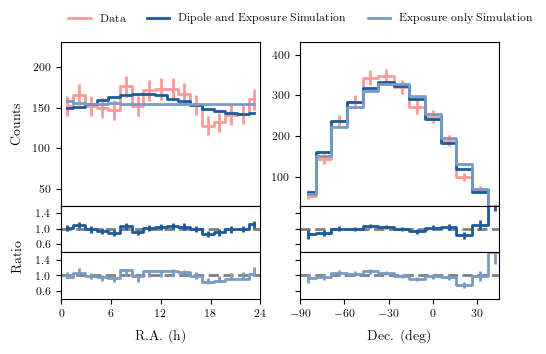

In [27]:
fig, ax = plt.subplots(3,2, figsize=(set_size('prx_wide', fraction=0.8, subplots=(3, 2), height_ratio =[3.5,1,1])), height_ratios=[3.5,1,1], sharex = 'col', gridspec_kw = {'hspace': 0})

ax[0][0].step(get_bin_centers(ra_bins)*12/np.pi, hist_ra, color = reds[2], where = 'mid', label = 'Data')
ax[0][0].errorbar(get_bin_centers(ra_bins)*12/np.pi, hist_ra, np.sqrt(hist_ra),color = reds[2], fmt = 'None')
ax[0][0].step(get_bin_centers(ra_bins)*12/np.pi,ra_dip_avg, color = blues[0], where = 'mid', label = 'Dipole and Exposure Simulation')
ax[0][0].step(get_bin_centers(ra_bins)*12/np.pi,ra_exp_avg, color = blues[2], where = 'mid', label = 'Exposure only Simulation')
ax[0][0].set_ylim(0,170)
ax[0][0].legend(frameon = False, ncols = 3, bbox_to_anchor=(1.2, 1.05), loc='lower center')
ax[0][0].set_ylabel('Counts')
ax[0][0].set_yticks(np.arange(0, 230, 50))
ax[0][0].set_ylim(30, 230)

ax[1][0].step(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_dip_avg,c = blues[0],  where = 'mid',label = 'Dipole and Exposure Ratio')
ax[1][0].errorbar(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_dip_avg, np.sqrt(hist_ra)/ra_dip_avg, c = blues[0],  fmt='None')
# ax[1][0].step(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_exp_avg, c= blues[2],  where = 'mid',label = 'Exposure only Ratio')
# ax[1][0].errorbar(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_dip_avg, np.sqrt(hist_ra)/ra_exp_avg, c = blues[1],  fmt='None')
ax[1][0].axhline(1, ls = '--', c = 'grey', zorder = -1)
# ax[1][0].set_ylim(0.4,1.6)
ax[1][0].set_ylim(0.4,1.6)
ax[1][0].set_yticks([0.6,1,1.4])
ax[1][0].set_xlabel('R.A. (h)')
ax[1][0].set_xticks(np.arange(0,30,6))
ax[1][0].set_xlim(0,24)
ax[1][0].set_ylabel('Ratio', y = -0.1)

ax[2][0].step(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_exp_avg,c = blues[2],  where = 'mid',label = 'Dipole and Exposure Ratio')
ax[2][0].errorbar(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_dip_avg, np.sqrt(hist_ra)/ra_dip_avg, c = blues[2],  fmt='None')
ax[2][0].axhline(1, ls = '--', c = 'grey', zorder = -1)
# ax[1][0].set_ylim(0.4,1.6)
ax[2][0].set_ylim(0.4,1.6)
ax[2][0].set_yticks([0.6,1,1.4])
ax[2][0].set_xlabel('R.A. (h)')
ax[2][0].set_xticks(np.arange(0,30,6))
ax[2][0].set_xlim(0,24)

ax[0][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec, color = reds[2],where = 'mid', label = 'Data')
ax[0][1].errorbar(np.degrees(get_bin_centers(dec_bins)), hist_dec, np.sqrt(hist_dec), color = reds[2], fmt = 'None')
ax[0][1].step(np.degrees(get_bin_centers(dec_bins)),dec_dip_avg, color = blues[0], where = 'mid',label = 'Dipole and Exposure Simulation')
ax[0][1].step(np.degrees(get_bin_centers(dec_bins)),dec_exp_avg, color = blues[2], where = 'mid',label = 'Exposure Simulation')
ax[0][1].set_yticks(np.arange(0, 450, 100))
ax[0][1].set_ylim(30, 430)


ax[1][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg,c = blues[0], where = 'mid', label = 'Dipole and Exposure Ratio')
ax[1][1].errorbar(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg, np.sqrt(hist_dec)/dec_dip_avg,c = blues[0],fmt = 'None', label = 'Dipole and Exposure Ratio')
ax[1][1].axhline(1, ls = '--', c = 'grey', zorder = -1)
ax[1][1].set_ylim(0.4,1.6)
ax[1][1].set_yticks([0.6,1,1.4])
ax[1][1].set_yticklabels(['','',''])
ax[1][1].set_xlim(-90,44.8)
ax[1][1].set_xticks(np.arange(-90,50,30))
ax[1][1].set_xlabel('Dec. (deg)')

ax[2][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_exp_avg, c= blues[2], where = 'mid',label = 'Exposure only Ratio')
ax[2][1].errorbar(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_exp_avg, np.sqrt(hist_dec)/dec_exp_avg,c = blues[2],fmt = 'None', label = 'Dipole and Exposure Ratio')
ax[2][1].axhline(1, ls = '--', c = 'grey', zorder = -1)
ax[2][1].set_ylim(0.4,1.6)
ax[2][1].set_yticks([0.6,1,1.4])
ax[2][1].set_yticklabels(['','',''])
ax[2][1].set_xlim(-90,44.8)
ax[2][1].set_xticks(np.arange(-90,50,30))
ax[2][1].set_xlabel('Dec. (deg)')


plt.savefig('plots/KS_test.png')

/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/4070998637.py:27: RuntimeWarning: invalid value encountered in divide
  ax[1][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg, where = 'mid',c = 'k')
/var/folders/fk/wtd7q1cd3dj875v4s60j7xvm0000gn/T/ipykernel_10868/4070998637.py:28: RuntimeWarning: invalid value encountered in divide
  ax[1][1].errorbar(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg, np.sqrt(hist_dec)/dec_dip_avg,fmt = 'None',c = 'k')


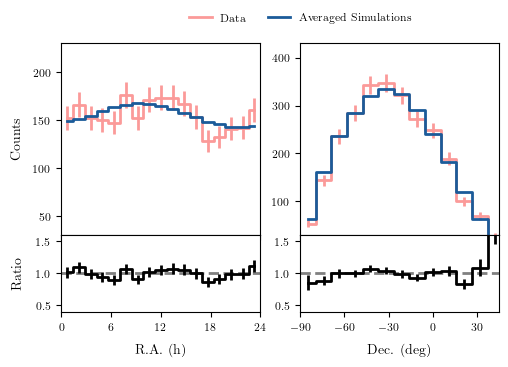

In [28]:
fig, ax = plt.subplots(2,2, figsize=(set_size('prx_wide', fraction=0.8, subplots=(2, 2), height_ratio =[2.5])), height_ratios=[2.5,1], sharex = 'col', gridspec_kw = {'hspace': 0})

ax[0][0].step(get_bin_centers(ra_bins)*12/np.pi, hist_ra,where='mid', color = reds[2],label = 'Data')
ax[0][0].errorbar(get_bin_centers(ra_bins)*12/np.pi, hist_ra, np.sqrt(hist_ra), fmt = 'None', color = reds[2])
ax[0][0].step(get_bin_centers(ra_bins)*12/np.pi,ra_dip_avg, color = blues[0],where = 'mid', label = 'Averaged Simulations')
ax[0][0].set_ylim(0,170)
ax[0][0].legend(frameon = False, ncols = 2, bbox_to_anchor=(1.2, 1.05), loc='lower center')
ax[0][0].set_ylabel('Counts')
ax[0][0].set_yticks(np.arange(0, 230, 50))
ax[0][0].set_ylim(30, 230)

ax[1][0].step(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_dip_avg,where='mid',c = 'k')
ax[1][0].errorbar(get_bin_centers(ra_bins)*12/np.pi, hist_ra/ra_dip_avg, np.sqrt(hist_ra)/ra_dip_avg,fmt = 'None',c = 'k')
ax[1][0].axhline(1, ls = '--', c = 'grey', zorder = -1)
ax[1][0].set_ylim(0.4,1.6)
ax[1][0].set_xlabel('R.A. (h)')
ax[1][0].set_xticks(np.arange(0,30,6))
ax[1][0].set_xlim(0,24)
ax[1][0].set_ylabel('Ratio')

ax[0][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec, where = 'mid', color = reds[2])
ax[0][1].errorbar(np.degrees(get_bin_centers(dec_bins)),hist_dec, np.sqrt(hist_dec),fmt = 'None', color = reds[2])
ax[0][1].step(np.degrees(get_bin_centers(dec_bins)), dec_dip_avg,where = 'mid',color = blues[0])
ax[0][1].set_yticks(np.arange(0, 450, 100))
ax[0][1].set_ylim(30, 430)

ax[1][1].step(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg, where = 'mid',c = 'k')
ax[1][1].errorbar(np.degrees(get_bin_centers(dec_bins)), hist_dec/dec_dip_avg, np.sqrt(hist_dec)/dec_dip_avg,fmt = 'None',c = 'k')
ax[1][1].axhline(1, ls = '--', c = 'grey', zorder = -1)
ax[1][1].set_ylim(0.4,1.6)
ax[1][1].set_xlim(-90,44.8)
ax[1][1].set_xticks(np.arange(-90,50,30))
ax[1][1].set_xlabel('Dec. (deg)')

plt.savefig('plots/fig_proceeding.png')
plt.savefig('plots/fig_proceeding.pdf')

There's basically no visible difference between the two simulated distirbutions. The KS test will tell us which of the two better describes the data.

Let's run the test!

In [29]:
ks_stat_iso, p_val_iso = stats.ks_2samp(hist_ra, ra_exp_avg)
ks_stat_dip, p_val_dip = stats.ks_2samp(hist_ra, ra_dip_avg)

ks_stat_iso_dec, p_val_iso_dec = stats.ks_2samp(hist_dec, dec_exp_avg)
ks_stat_dip_dec, p_val_dip_dec = stats.ks_2samp(hist_dec, dec_dip_avg)

# Print results
print("KS Test Results:")
print(f"Exposure only KS Statistic: {ks_stat_iso:.6f}, p-value: {p_val_iso:.6f}")
print(f"Dipole and Exposure KS Statistic: {ks_stat_dip:.6f}, p-value: {p_val_dip:.6f}")

# Interpretation
if p_val_dip > p_val_iso:
    print("Data is more consistent with the dipole and exposure model.")
else:
    print("Data is more consistent with exposure only exposure.")

KS Test Results:
Exposure only KS Statistic: 0.588235, p-value: 0.004611
Dipole and Exposure KS Statistic: 0.235294, p-value: 0.750607
Data is more consistent with the dipole and exposure model.


KS Test Results:
Exposure only KS Statistic: 0.588235, p-value: 0.004611
Dipole and Exposure KS Statistic: 0.235294, p-value: 0.750607
Data is more consistent with the dipole and exposure model.

Both p-values are bad, but the p-values for the pdf including both the dipole and the exposure is better. This means that we can go on with the implementation we followed above!